# 2D toy model

## Segmentation pre-processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio.v3 as iio
import skimage
plt.rcParams['figure.figsize'] = (16,16)

### Illustration of segmentation on top of source image

An image illustrating the segmented cells superimposed on the original grayscale image

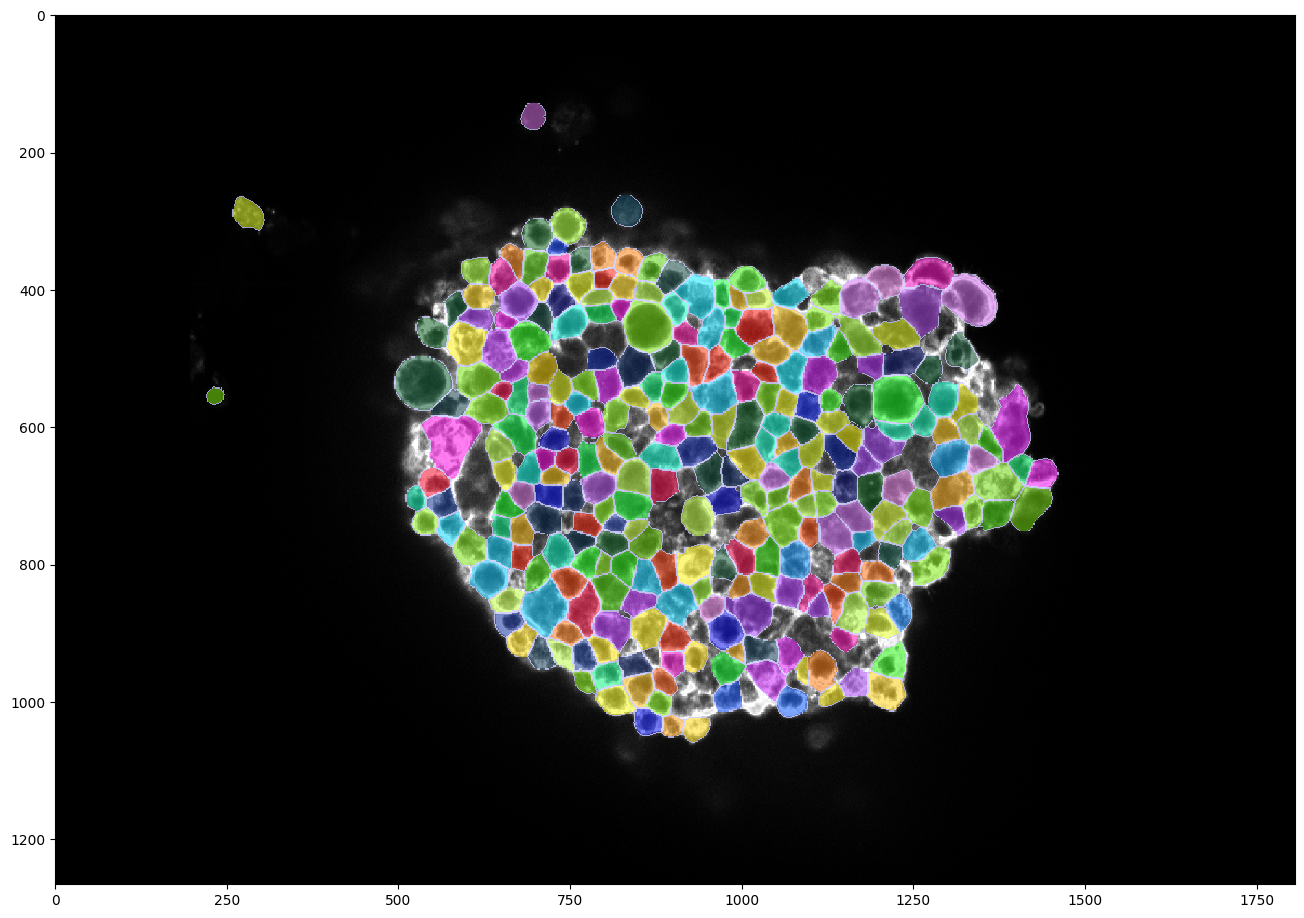

In [2]:
img_combined = iio.imread('C2-sph1_gly_au-0036_segmentedWithCellpose.png')
plt.imshow(img_combined, interpolation='none')

### Segmented indexed image

The segmented cells from the above image with a different value for each cell

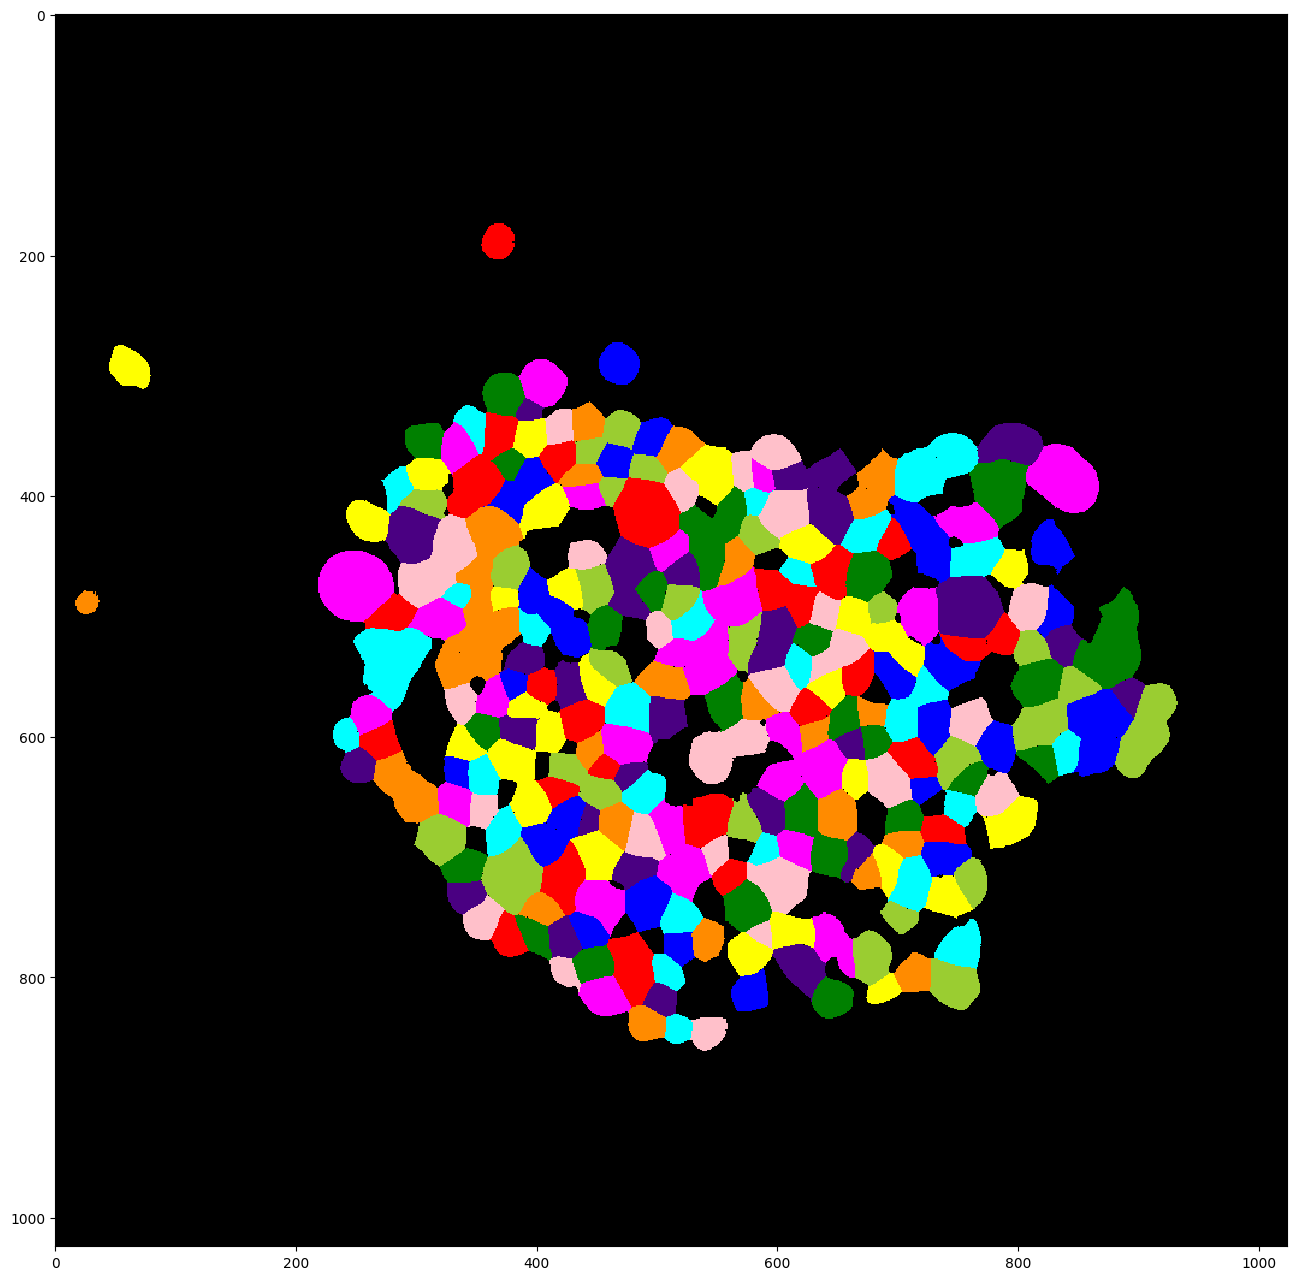

In [3]:
img_indexed = iio.imread('C2-sph1_gly_au-0036_cp_masks.png')
plt.imshow(skimage.color.label2rgb(img_indexed), interpolation='none')

### Generate explicit membranes by dilating each cell

- We want to add explicit membrane compartments around each cell.
- To do this we take a mask of each cell individually, dilate it, and select the pixels that differ from the original mask
- Repeating this over all cells and combining the results gives us a mask of membrane compartment pixels

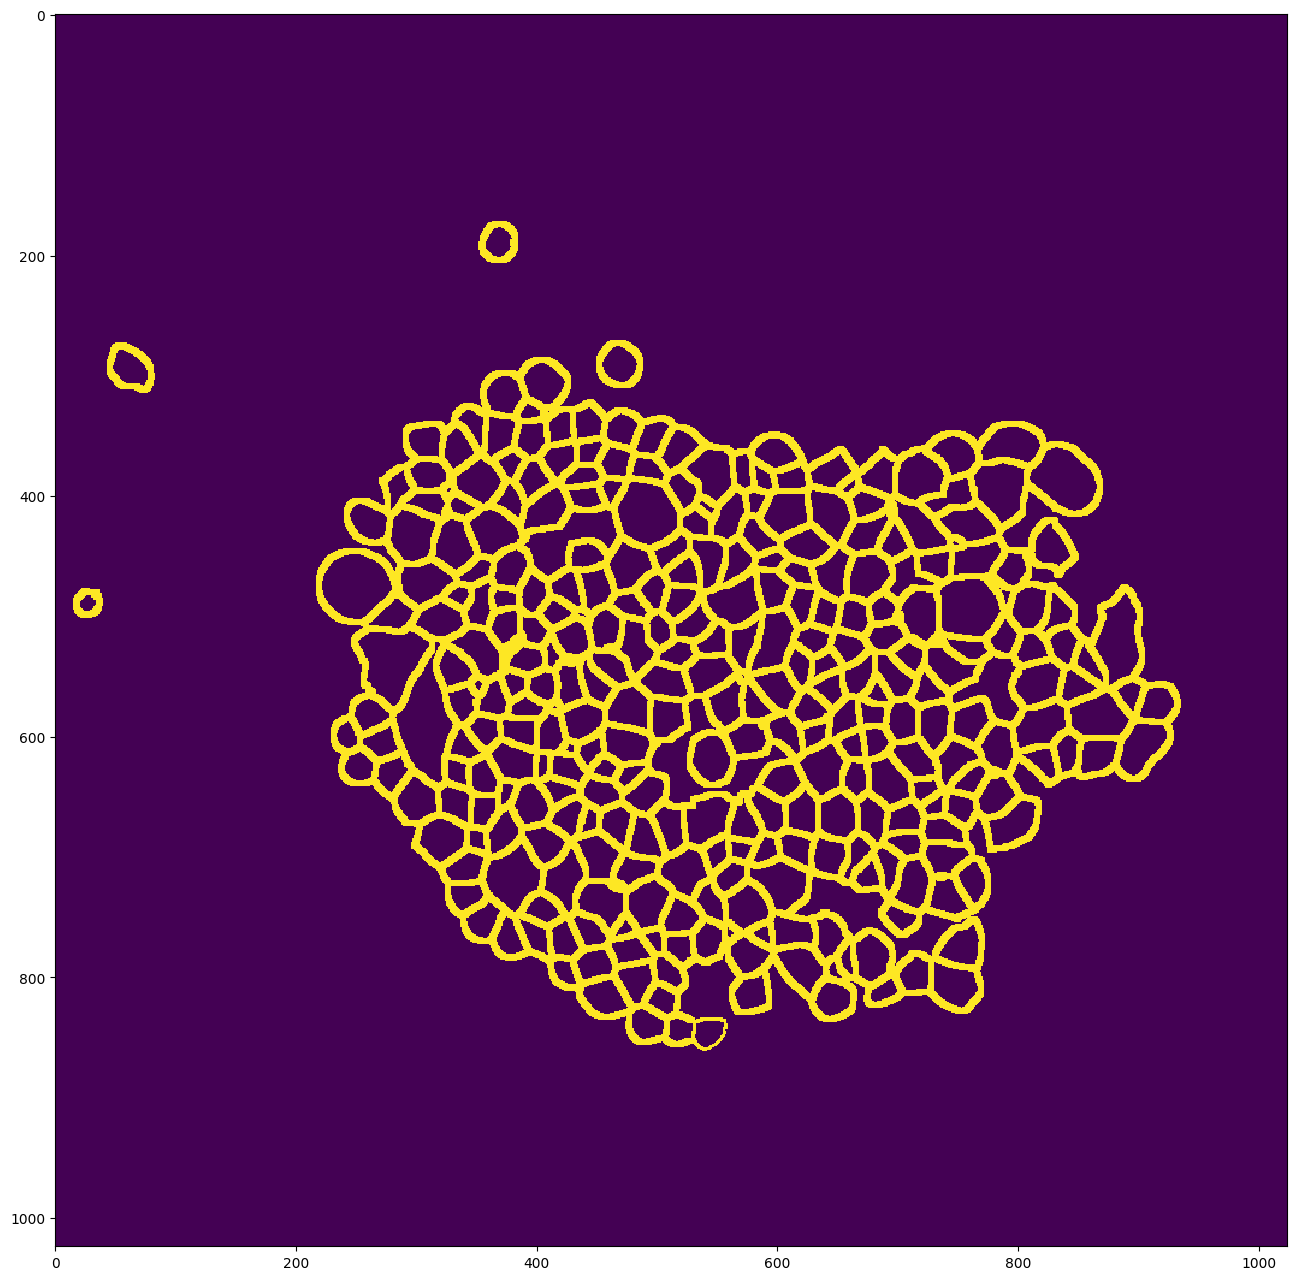

In [7]:
img_membrane_mask = np.zeros(img_indexed.shape).astype(bool)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6,6))
for index in range(img_indexed.max()):
    img = (img_indexed==index).astype(np.uint8)
    img_membrane_mask |= cv2.dilate(img, kernel) != img
plt.imshow(img_membrane_mask, interpolation='none')

### Generate cells as anything segmented excluding these membranes

- Now we select all pixels that were identified as cells
- Then we exclude pixels that are part of the membrane mask to leave a cell mask

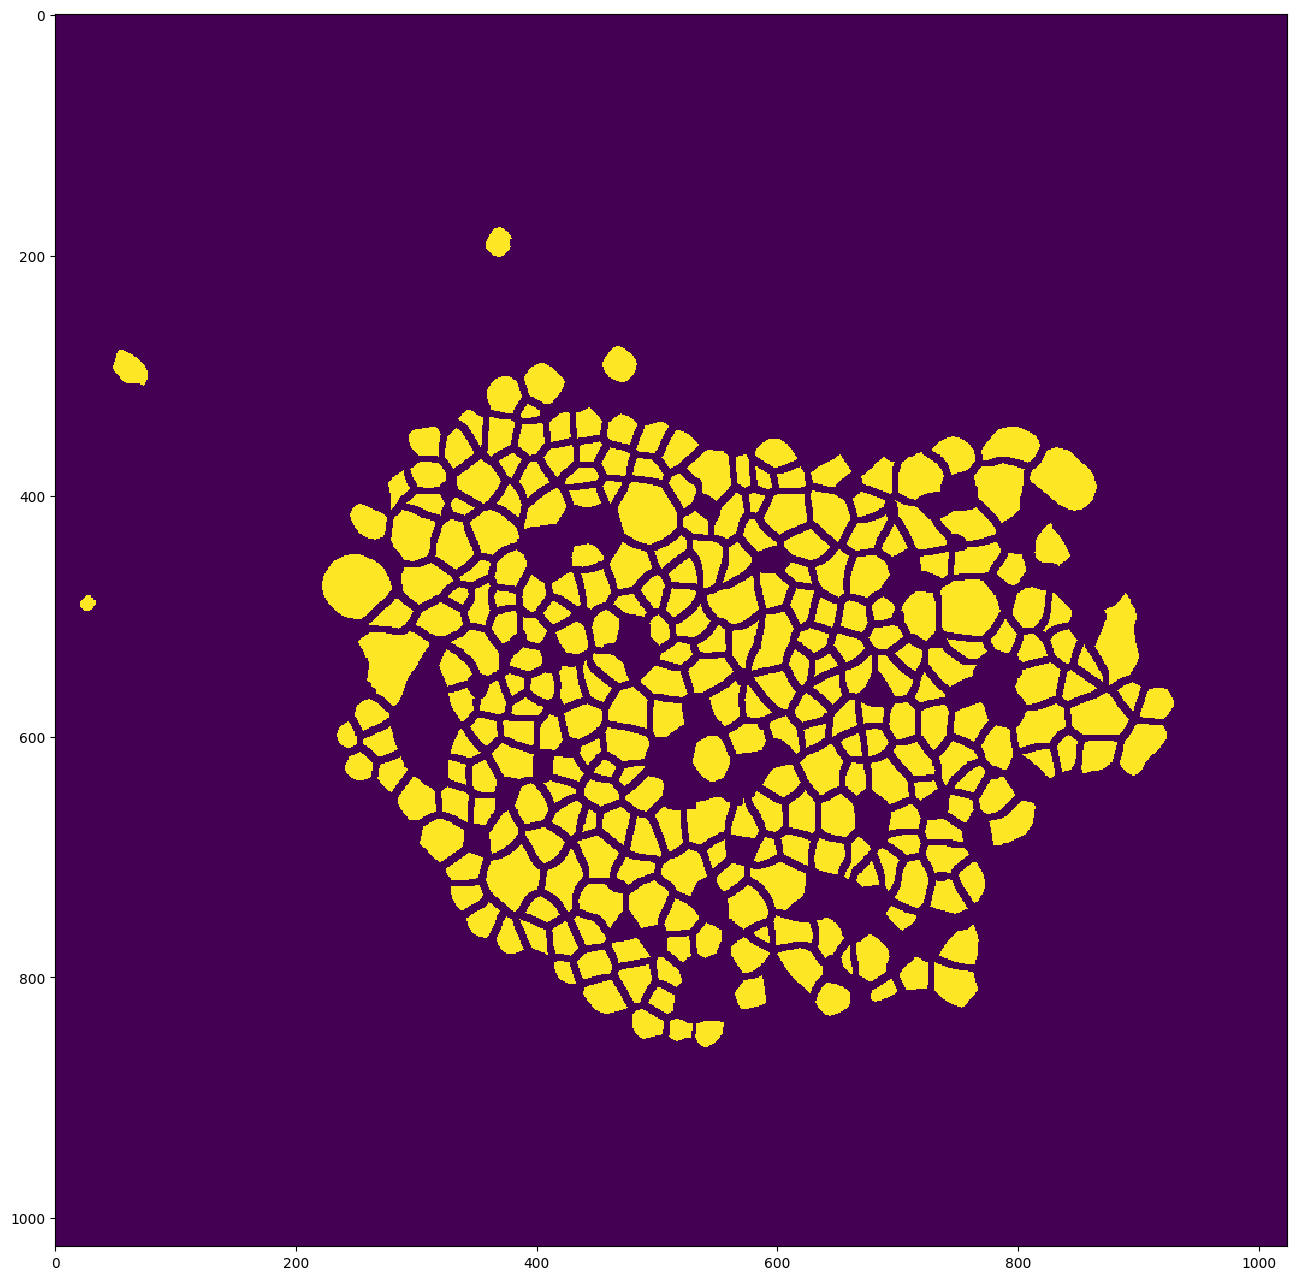

In [8]:
img_cell_mask = img_indexed!=0
img_cell_mask = img_cell_mask & (img_cell_mask!=img_membrane_mask)
plt.imshow(img_cell_mask, interpolation='none')

### Construct segmented geometry image for sme

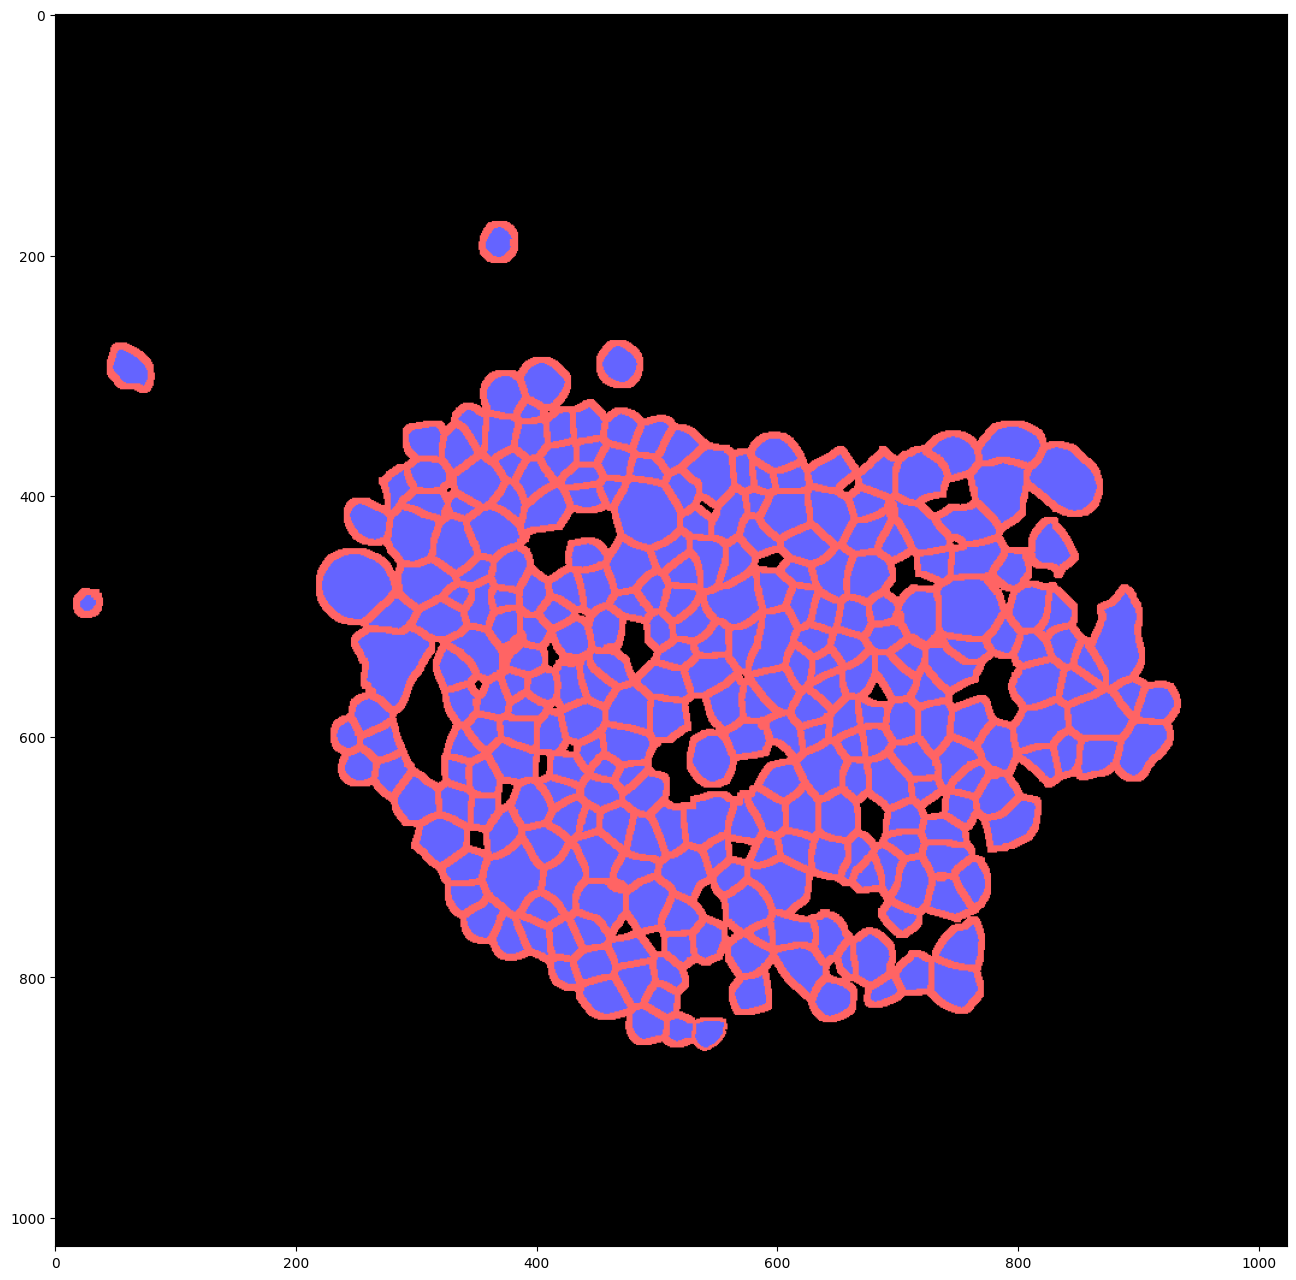

In [9]:
img = np.zeros((*img_cell_mask.shape, 3), dtype=np.uint8)
img[img_cell_mask] = [100,100,255]
img[img_membrane_mask] = [255,100,100]
plt.imshow(img)
iio.imwrite("geom.png", img)